# 01_EDA: Diabetes Dataset
Notebook: exploratory data analysis for diabetes, cardiovascular, and stroke datasets.

Loaded: diabetes_prediction_dataset.csv shape: (100000, 9)
Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
Using target column: diabetes
diabetes
0    91500
1     8500
Name: count, dtype: int64
After preprocessing, X shape: (100000, 13)

--- Random Forest Results ---
Accuracy : 0.9697
Precision: 0.9390
Recall   : 0.6876
F1 score : 0.7939
ROC AUC  : 0.9660

Classification report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.94      0.69      0.79      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000

Confusion matrix:
 [[18224    76]
 [  531  1169]]


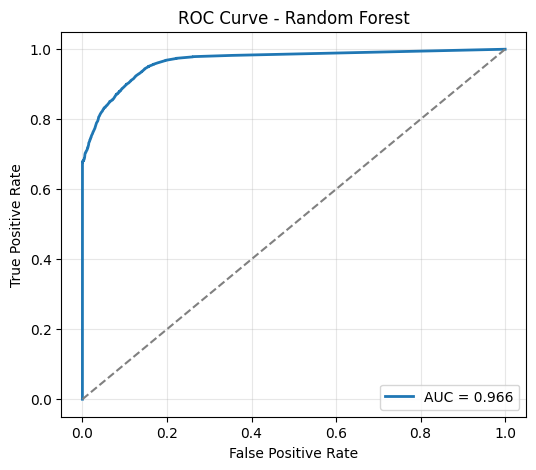

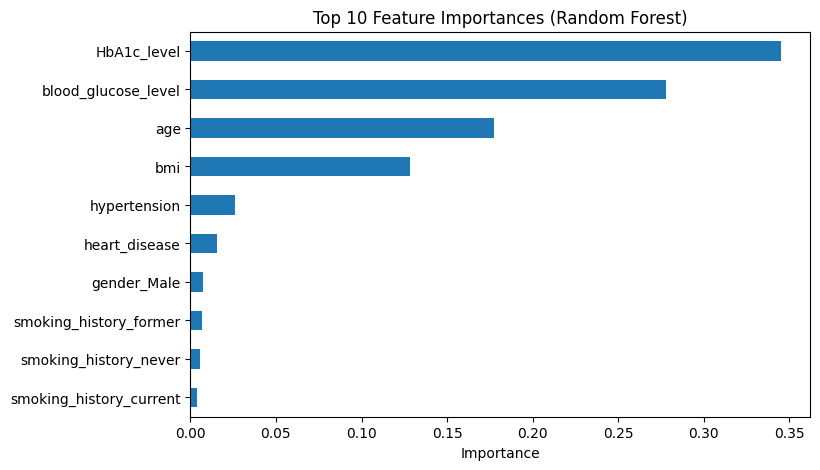

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

FNAME = "diabetes_prediction_dataset.csv"   # change if filename differs
if not os.path.exists(FNAME):
    raise FileNotFoundError(f"File not found in cwd: {FNAME}. Run os.listdir() to confirm location.")

# ---------- load ----------
df = pd.read_csv(FNAME)
print("Loaded:", FNAME, "shape:", df.shape)
print("Columns:", df.columns.tolist())

# ---------- detect target ----------
common_names = ['Outcome','outcome','diabetes','Diabetes','target','label','class']
target_col = None
for name in common_names:
    if name in df.columns:
        target_col = name
        break

if target_col is None:
    for col in df.columns:
        unique = df[col].dropna().unique()
        if len(unique) == 2:
            target_col = col
            break

if target_col is None:
    raise ValueError("Could not auto-detect a target column. Update 'common_names' or add a target column.")

print("Using target column:", target_col)
print(df[target_col].value_counts(dropna=False))

# ---------- normalize target to 0/1 if needed ----------
vals = df[target_col].dropna().unique()
if set(vals) <= {0,1}:
    pass
else:
    # map common textual labels -> 0/1
    map_yes = {'yes','Yes','Y','y','positive','Positive','true','True','1','t','T'}
    map_no  = {'no','No','N','n','negative','Negative','false','False','0','f','F'}
    def map_label(x):
        if pd.isna(x): return np.nan
        s = str(x).strip()
        if s in map_yes: return 1
        if s in map_no: return 0
        try:
            v = float(s)
            if v == 1: return 1
            if v == 0: return 0
        except:
            pass
        return np.nan
    df[target_col] = df[target_col].map(map_label)
    # fallback mapping if still NaN but there are exactly 2 unique textual values
    if df[target_col].isnull().any():
        uniq = pd.Series(df[target_col].astype(str)).unique()
        if len(uniq) == 2:
            mapping = {uniq[0]:0, uniq[1]:1}
            df[target_col] = df[target_col].astype(str).map(mapping)
    print("After mapping, target counts:\n", df[target_col].value_counts(dropna=False))

df = df[~df[target_col].isna()].copy()
df[target_col] = df[target_col].astype(int)

# ---------- preprocessing ----------
y = df[target_col]
X = df.drop(columns=[target_col])

# Numeric imputation
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Categorical one-hot
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
if len(cat_cols) > 0:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# final fill (in case)
X = X.fillna(X.median())

print("After preprocessing, X shape:", X.shape)

# ---------- train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------- train Random Forest ----------
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

# ---------- metrics ----------
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n--- Random Forest Results ---")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}\n")
print("Classification report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# ROC curve
fpr, tpr, th = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# ---------- feature importances (top 10) ----------
importances = clf.feature_importances_
feat_names = X.columns
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
fi.sort_values().plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()



In [4]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear', random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_auc = cross_val_score(rf, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
lr_auc = cross_val_score(lr, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)

print("RF AUC: {:.3f} ± {:.3f}".format(rf_auc.mean(), rf_auc.std()))
print("LR AUC: {:.3f} ± {:.3f}".format(lr_auc.mean(), lr_auc.std()))

RF AUC: 0.967 ± 0.002
LR AUC: 0.962 ± 0.001


In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt','log2', None]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rs = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1)
rs.fit(X, y)
print("Best AUC (cv):", rs.best_score_)
print("Best params:", rs.best_params_)
best_rf = rs.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best AUC (cv): 0.9761272192558481
Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}


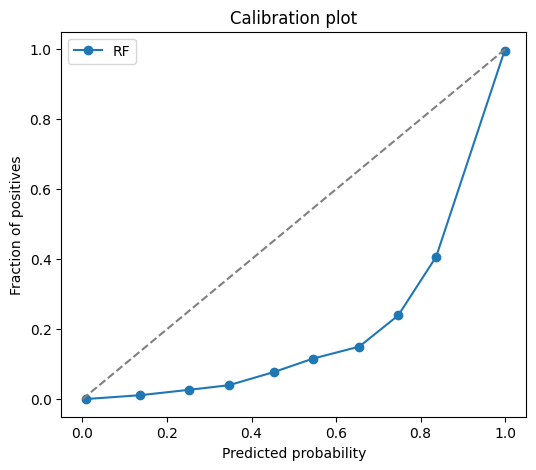

In [6]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import matplotlib.pyplot as plt

# Calibration plot 
y_proba = best_rf.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='RF')
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel('Predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.legend()
plt.show()

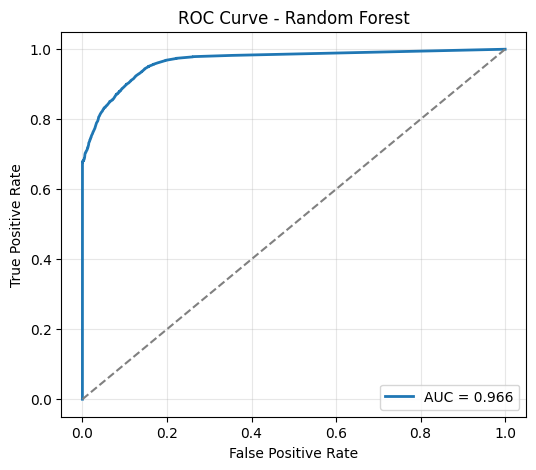

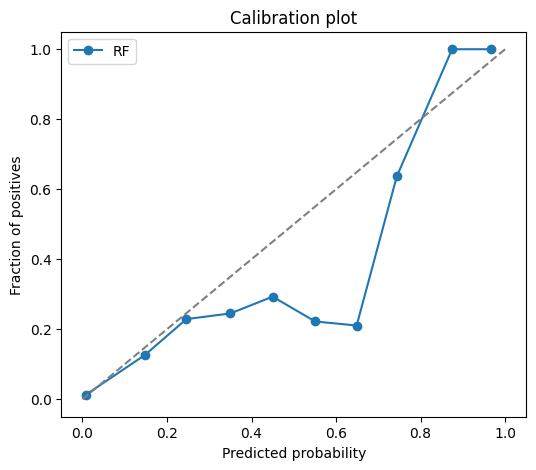

Saved outputs/latest_metrics.txt, outputs/rf_roc.png, outputs/rf_calibration.png
\nQuick metrics summary:
Accuracy: 0.9697, Precision: 0.9390, Recall: 0.6876, F1: 0.7939, ROC AUC: 0.9660, AUC-PR: 0.8617


In [7]:
# Save current results:
%matplotlib inline
import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, classification_report)
from sklearn.calibration import calibration_curve
import joblib

FNAME = "diabetes_prediction_dataset.csv"
if not os.path.exists(FNAME):
    raise FileNotFoundError(f"{FNAME} not found. Run os.listdir() to confirm location.")

# load and preprocess same as before (safe, minimal)
df = pd.read_csv(FNAME)
common_names = ['Outcome','outcome','diabetes','Diabetes','target','label','class']
target_col = next((c for c in common_names if c in df.columns), None)
if target_col is None:
    target_col = next((c for c in df.columns if df[c].nunique()==2), None)
if target_col is None:
    raise ValueError("Could not detect target column automatically. Inspect df.columns.")
y = df[target_col].copy()
X = df.drop(columns=[target_col])
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X.fillna(X.median())

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# load tuned model if exists, else train a quick RF
MODEL_PATH = "models/rf_best.joblib"
if os.path.exists(MODEL_PATH):
    model = joblib.load(MODEL_PATH)
else:
    model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

# ensure fitted
try:
    _ = model.predict(X_test[:1])
except Exception:
    model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)
auc_pr = average_precision_score(y_test, y_proba)
report = classification_report(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

# save metrics file
os.makedirs("outputs", exist_ok=True)
with open("outputs/latest_metrics.txt", "w") as f:
    f.write("Holdout metrics (Random Forest)\\n")
    f.write(f"Accuracy: {acc:.4f}\\nPrecision: {prec:.4f}\\nRecall: {rec:.4f}\\nF1: {f1:.4f}\\nROC AUC: {roc_auc:.4f}\\nAUC-PR: {auc_pr:.4f}\\n\\n")
    f.write("Classification report:\\n")
    f.write(report)
    f.write("\\nConfusion matrix:\\n")
    f.write(str(cm))

# ROC plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig("outputs/rf_roc.png", bbox_inches='tight')
plt.show()

# Calibration plot
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='RF')
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel('Predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.legend()
plt.savefig("outputs/rf_calibration.png", bbox_inches='tight')
plt.show()

print("Saved outputs/latest_metrics.txt, outputs/rf_roc.png, outputs/rf_calibration.png")
print("\\nQuick metrics summary:")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}, AUC-PR: {auc_pr:.4f}")

In [8]:
# ---------- Cardivascular analysis---------------
import pandas as pd

df= pd.read_csv("cardio_train.csv", sep=';')

df.columns = [col.strip() for col in df.columns]

df = df.astype({
    "id": int,
    "age": int,
    "gender": int,
    "height": float,
    "weight": float,
    "ap_hi": int,
    "ap_lo": int,
    "cholesterol": int,
    "gluc": int,
    "smoke": int,
    "alco": int,
    "active": int,
    "cardio": int
})

print(df.head(5))
print("Columns:", df.columns.tolist()) 
print("Shape:", df.shape)





   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2   168.0    62.0    110     80            1     1      0   
1   1  20228       1   156.0    85.0    140     90            3     1      0   
2   2  18857       1   165.0    64.0    130     70            3     1      0   
3   3  17623       2   169.0    82.0    150    100            1     1      0   
4   4  17474       1   156.0    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  
Columns: ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
Shape: (70000, 13)


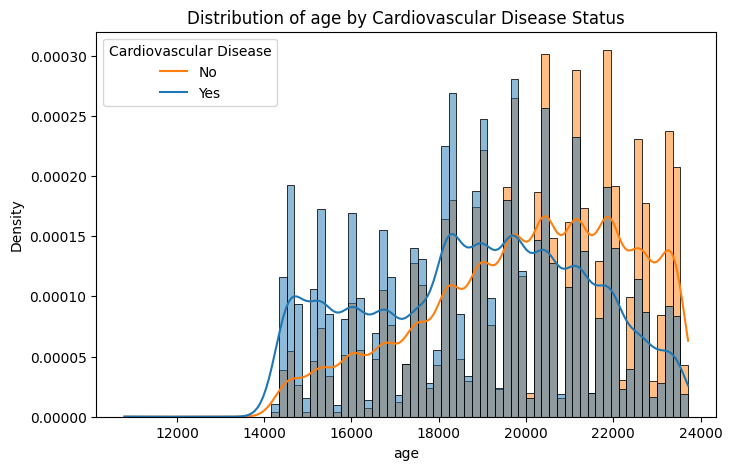

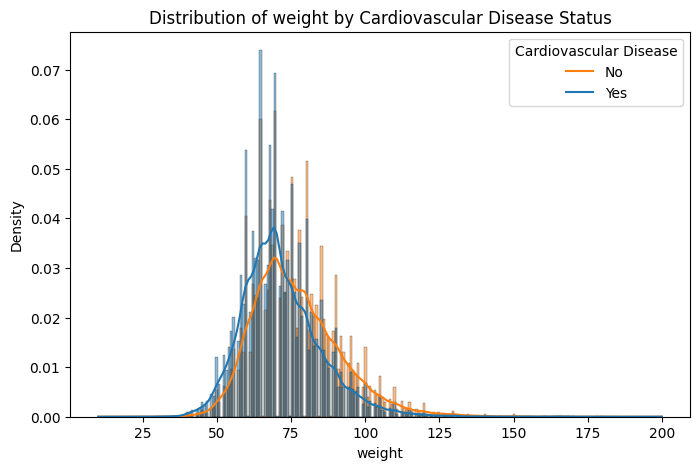

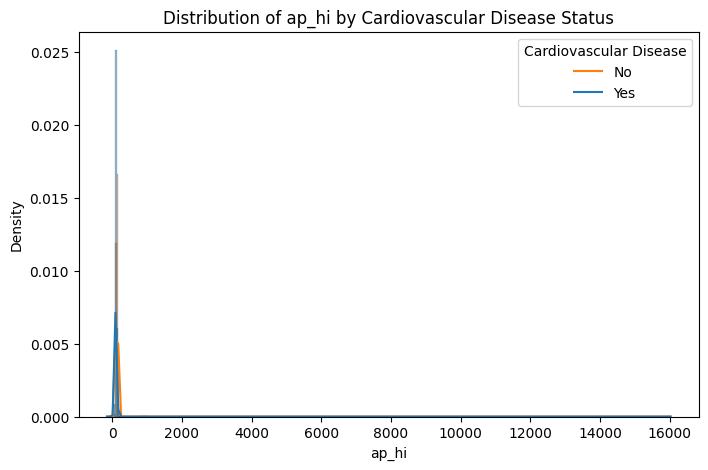

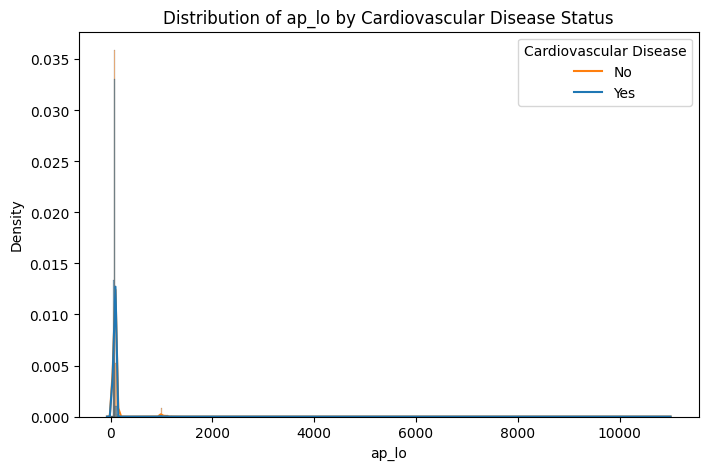

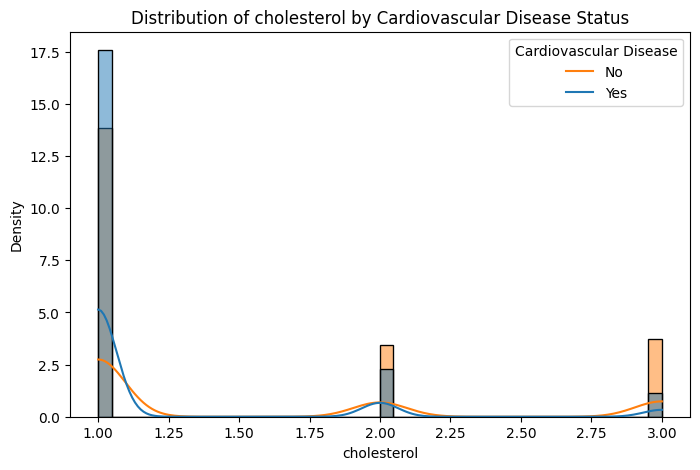

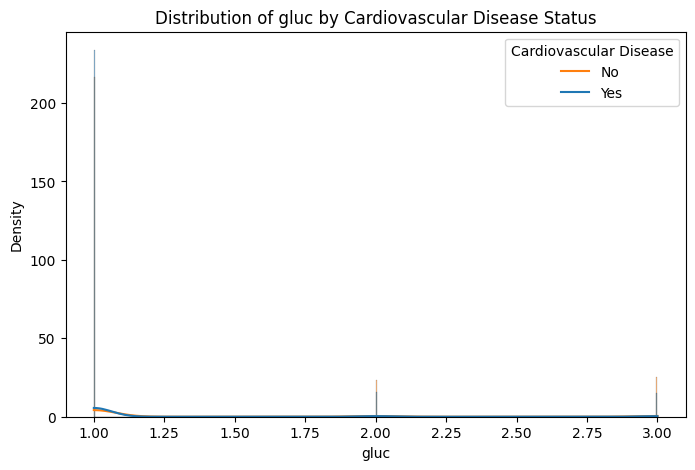

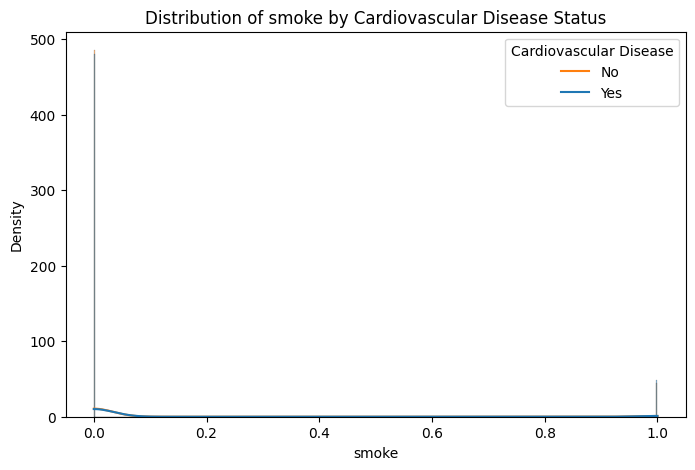

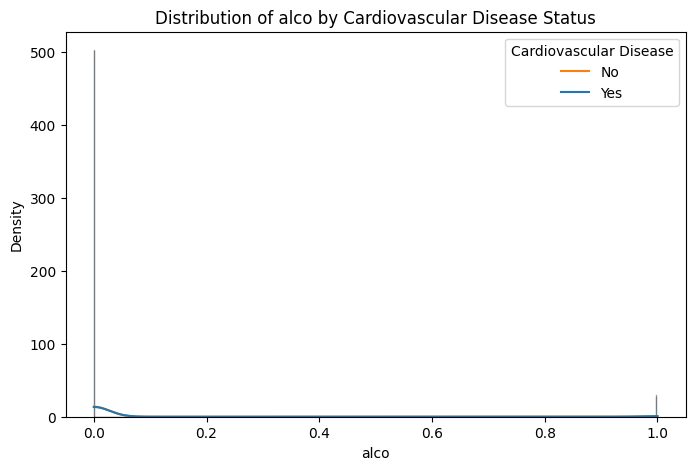

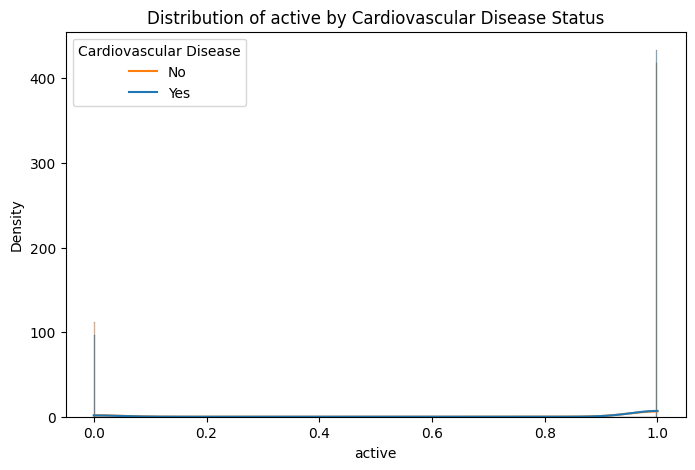

In [9]:
#----------------Distribution plot for different variables---------------
import seaborn as sns
import matplotlib.pyplot as plt

variables = ['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=var, hue='cardio', kde=True, stat="density", common_norm=False)
    plt.title(f'Distribution of {var} by Cardiovascular Disease Status')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend(title='Cardiovascular Disease', labels=['No', 'Yes'])
    plt.show()

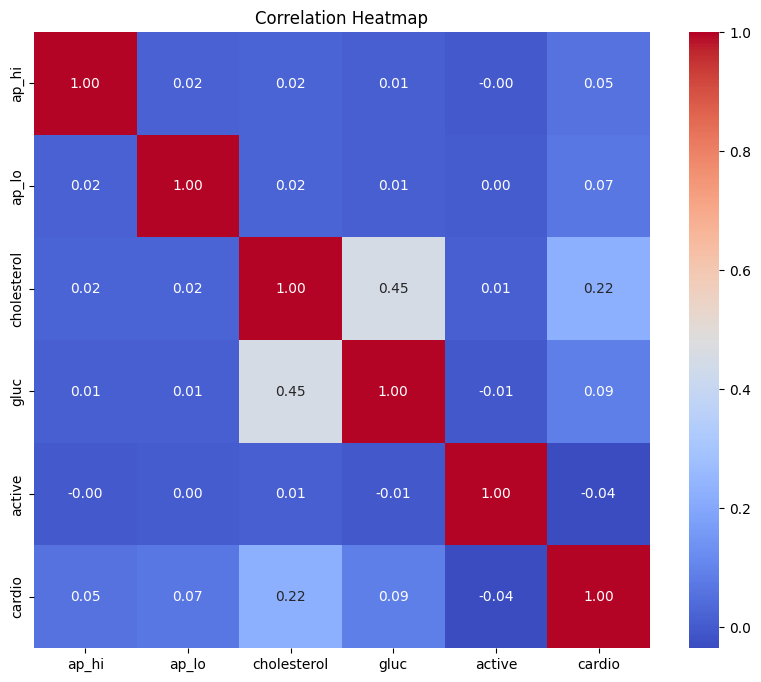

In [10]:
#--- Heatmap of correlations ---
plt.figure(figsize=(10,8))

corr_cols = ['ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'active','cardio']
corr_matrix= df[corr_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.title('Correlation Heatmap')
plt.show()



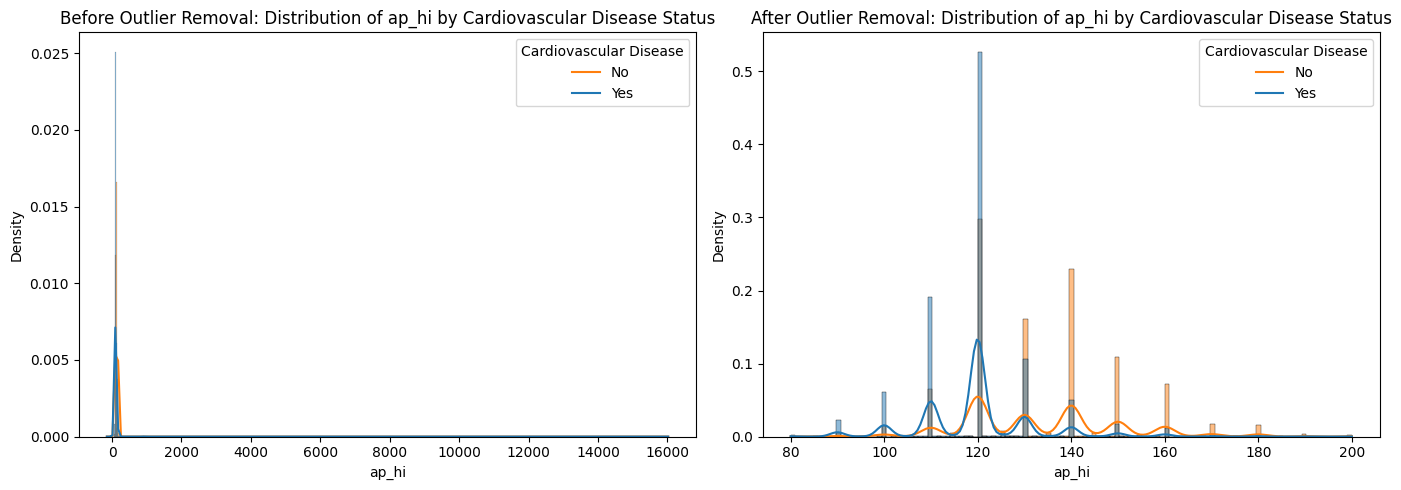

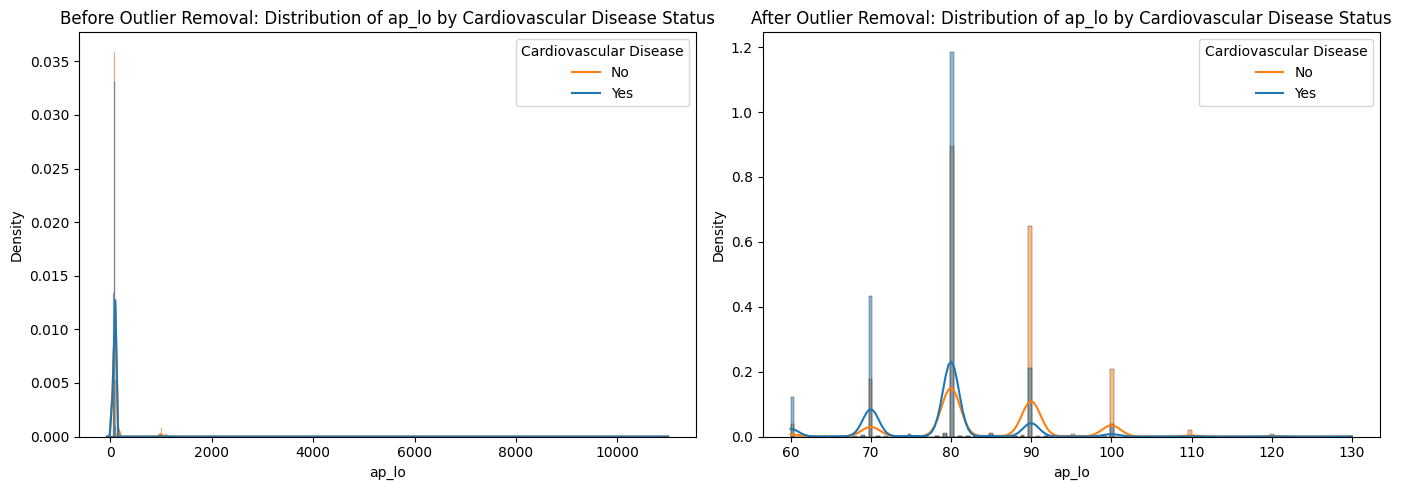

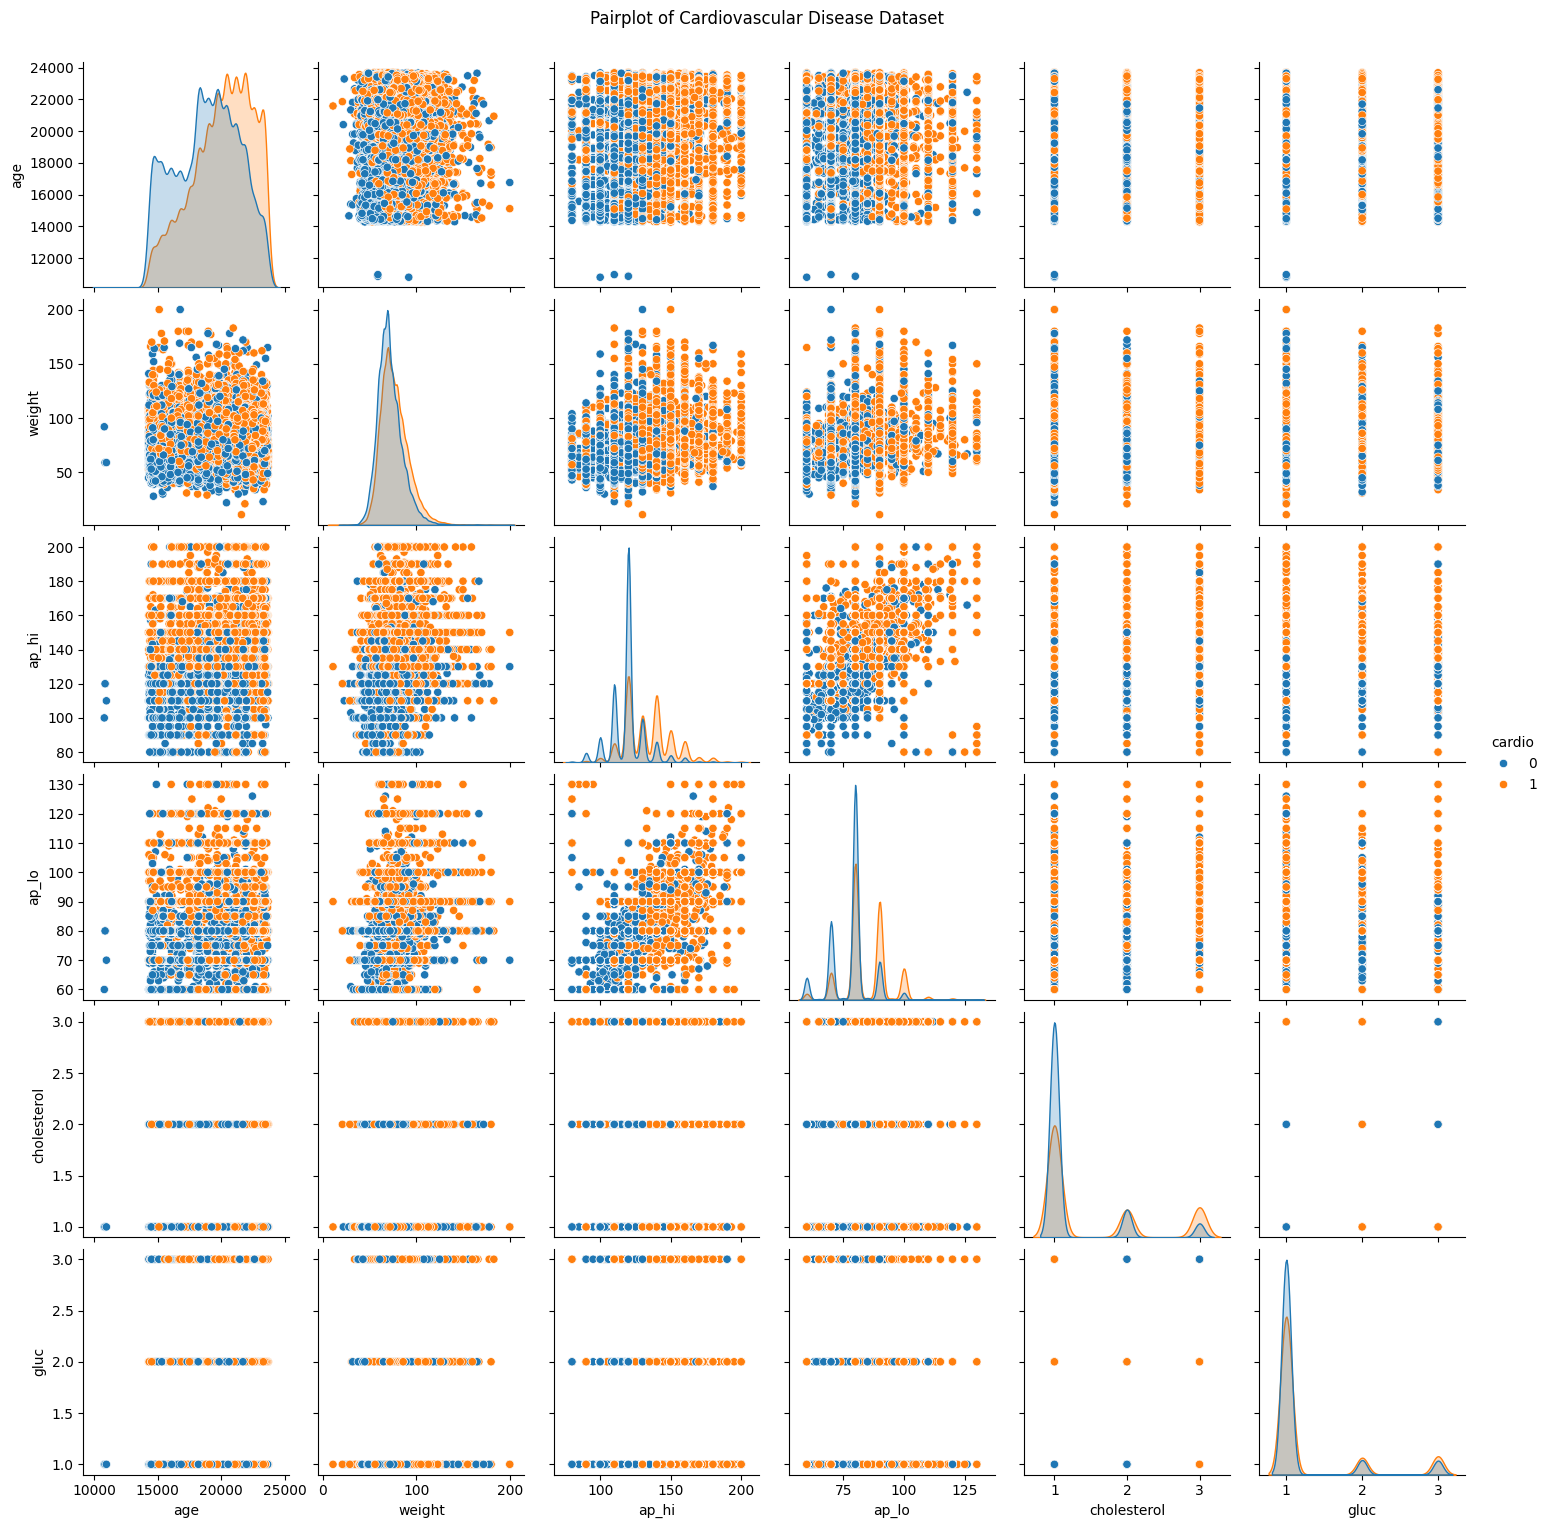

In [11]:
#-------Remove outliers for ap_hi and ap_lo variables-------
df_cleaned = df[(df['ap_hi'] >= 80) & (df['ap_hi'] <= 200) &
                (df['ap_lo'] >= 60) & (df['ap_lo'] <= 130)]

#-------Compare distributions before and after outlier removal-------
import seaborn as sns
import matplotlib.pyplot as plt 
variables = ['ap_hi', 'ap_lo']
for var in variables:
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=var, hue='cardio', kde=True, stat="density", common_norm=False)
    plt.title(f'Before Outlier Removal: Distribution of {var} by Cardiovascular Disease Status')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend(title='Cardiovascular Disease', labels=['No', 'Yes'])

    plt.subplot(1, 2, 2)
    sns.histplot(data=df_cleaned, x=var, hue='cardio', kde=True, stat="density", common_norm=False)
    plt.title(f'After Outlier Removal: Distribution of {var} by Cardiovascular Disease Status')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend(title='Cardiovascular Disease', labels=['No', 'Yes'])

    plt.tight_layout()
    plt.show()

#-------Save cleaned data to new CSV file-------
df_cleaned.to_csv("cardio_train_cleaned.csv", index=False)

#-------Pairplot to visualize relationships-------
sns.pairplot(df_cleaned, hue='cardio', vars=['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc'])
plt.suptitle('Pairplot of Cardiovascular Disease Dataset', y=1.02)
plt.show()



Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
Shape: (5110, 12)
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed   

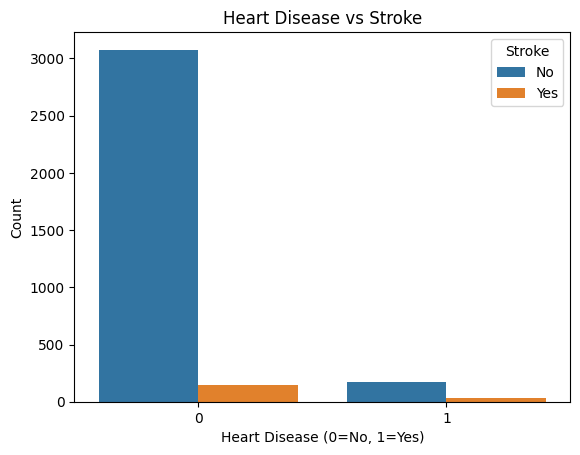

/tmp/ipykernel_6623/3653767930.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_stroke['smoking_status'] = df_stroke['smoking_status'].replace({


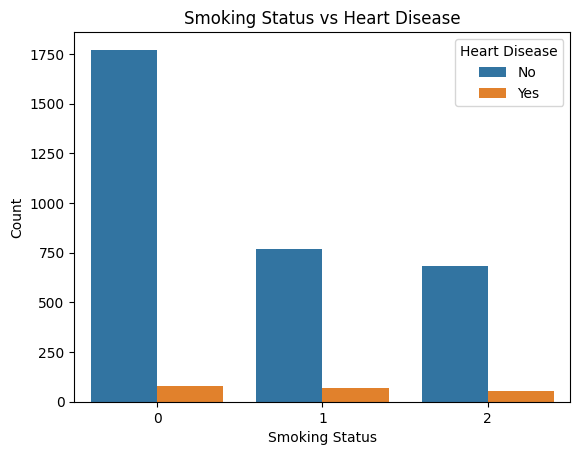

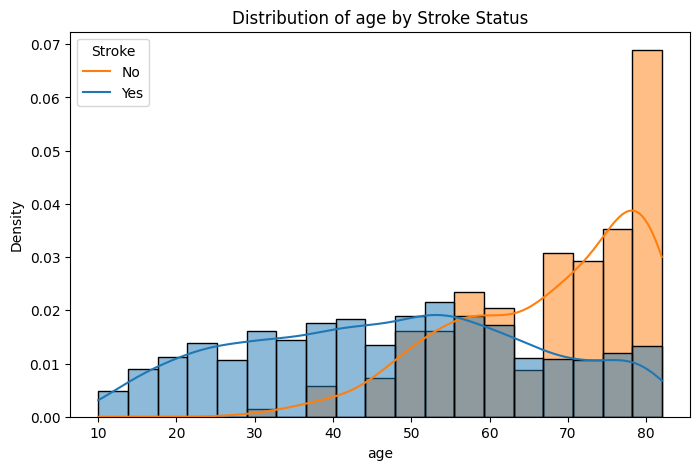

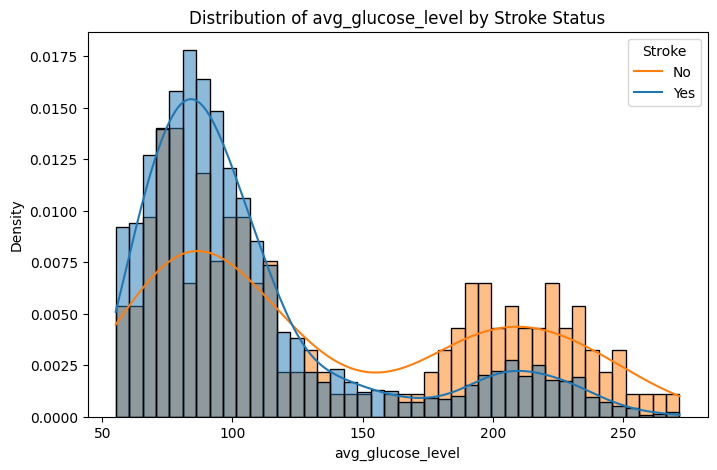

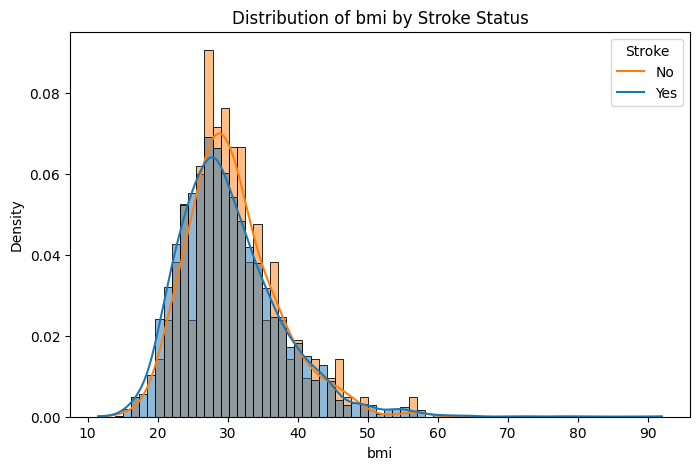

In [12]:
#------Acess Healthcare-dataset-stroke-data-------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
print(df.head(5))

#Create new data frame with gender-age-hear_disease-gluclevel-bmi-smokingstatus-stroke:
df_stroke = df[['gender', 'age', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']]
print("Stroke DataFrame shape:", df_stroke.shape)
print(df_stroke.head(5))

#Drop NA or Unknown values:
df_stroke = df_stroke.dropna()
df_stroke = df_stroke[df_stroke.ne('Unknown').all(axis=1)]

#Graph compare between heart_disease and stroke:
sns.countplot(data=df_stroke, x='heart_disease', hue='stroke')
plt.title('Heart Disease vs Stroke')
plt.xlabel('Heart Disease (0=No, 1=Yes)')
plt.ylabel('Count')
plt.legend(title='Stroke', labels=['No', 'Yes'])
plt.show()

#Sorting data in smoking_status column:
df_stroke['smoking_status'] = df_stroke['smoking_status'].replace({
    'formerly smoked': 1,
    'never smoked': 0,
    'smokes': 2,
    'Unknown': np.nan})

#Graph compare between smoking_status and heart_disease:
sns.countplot(data=df_stroke, x='smoking_status', hue='heart_disease')
plt.title('Smoking Status vs Heart Disease')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No', 'Yes'])
plt.show()

#Distribution plots for different variables in stroke dataset
variables = ['age', 'avg_glucose_level', 'bmi']
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df_stroke, x=var, hue='stroke', kde=True, stat="density", common_norm=False)
    plt.title(f'Distribution of {var} by Stroke Status')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend(title='Stroke', labels=['No', 'Yes'])
    plt.show()

In [13]:
import pandas as pd
import numpy as np

# ===============================
# 1. Load Datasets
# ===============================
df_cardio = pd.read_csv("cardio_train_cleaned.csv")
df_stroke = pd.read_csv("healthcare-dataset-stroke-data.csv")
df_diabetes = pd.read_csv("diabetes_prediction_dataset.csv")

# ===============================
# 2. Standardize Cardio Dataset
# ===============================
df_cardio.rename(columns={
    'cholesterol': 'cholesterol_level',
    'ap_hi': 'systolic_bp',
    'ap_low': 'diastolic_bp',
    'age_years': 'age',
    'cardio': 'cardio_disease',
    'gluc': 'glucose',
    'alco': 'alcohol'
}, inplace=True)

# smoking: 0 = never, 1 = current
if 'smoke' in df_cardio.columns:
    df_cardio.rename(columns={'smoke': 'smoking_status'}, inplace=True)
    df_cardio['smoking_status'] = df_cardio['smoking_status'].map({
        0: 'never',
        1: 'current'
    })

# Add missing columns
for col in ['heart_disease', 'diabetes', 'stroke']:
    df_cardio[col] = 0

# ensure bmi exists
df_cardio['bmi'] = df_cardio.get('bmi', np.nan)

# drop age
df_cardio.drop(columns=['age'], errors='ignore', inplace=True)


# ===============================
# 3. Standardize Stroke Dataset
# ===============================
df_stroke.rename(columns={
    'ever_married': 'married',
    'avg_glucose_level': 'glucose'
}, inplace=True)

if 'smoking_history' in df_stroke.columns:
    df_stroke.rename(columns={'smoking_history': 'smoking_status'}, inplace=True)

# Add missing columns
for col in ['cardio_disease', 'diabetes']:
    df_stroke[col] = 0

df_stroke['bmi'] = df_stroke.get('bmi', np.nan)

df_stroke.drop(columns=['age'], errors='ignore', inplace=True)


# ===============================
# 4. Standardize Diabetes Dataset
# ===============================
df_diabetes.rename(columns={
    'HbA1c_level': 'hba1c',
    'blood_glucose_level': 'glucose'
}, inplace=True)

if 'smoking_history' in df_diabetes.columns:
    df_diabetes.rename(columns={'smoking_history': 'smoking_status'}, inplace=True)

# Add missing columns
for col in ['heart_disease', 'stroke', 'cardio_disease']:
    df_diabetes[col] = 0

df_diabetes['bmi'] = df_diabetes.get('bmi', np.nan)

df_diabetes.drop(columns=['age'], errors='ignore', inplace=True)


# ===============================
# 5. Clean Smoking Status (All Datasets)
# ===============================
def clean_smoking_status(value):
    if pd.isna(value):
        return None
    v = str(value).strip().lower()

    if v in ["no info", "unknown"]:
        return None
    if v == "not current":
        return "current"         # your rule: not current → current
    if v == "ever":
        return "former"          # your rule: ever → former
    return v

for df in [df_cardio, df_stroke, df_diabetes]:
    df['smoking_status'] = df['smoking_status'].apply(clean_smoking_status)
    df.dropna(subset=['smoking_status'], inplace=True)


# ===============================
# 6. Align Columns for Concatenation
# ===============================
COMMON_COLS = [
    'bmi', 'smoking_status',
    'heart_disease', 'stroke', 'cardio_disease', 'diabetes'
]

df_cardio_aligned   = df_cardio[COMMON_COLS].copy()
df_stroke_aligned   = df_stroke[COMMON_COLS].copy()
df_diabetes_aligned = df_diabetes[COMMON_COLS].copy()


# ===============================
# 7. Concatenate All Datasets
# ===============================
df_combined = pd.concat(
    [df_cardio_aligned, df_stroke_aligned, df_diabetes_aligned],
    ignore_index=True
)

print("Data Alignment and Cleaning Complete.")
print("Final combined shape:", df_combined.shape)
print(df_combined['smoking_status'].value_counts())

# You asked to drop BMI:
df_combined.drop(columns=['bmi'], inplace=True)

df_combined.head()



Data Alignment and Cleaning Complete.
Final combined shape: (136293, 6)
smoking_status
never              97611
current            21760
former             13356
never smoked        1892
formerly smoked      885
smokes               789
Name: count, dtype: int64


,smoking_status,heart_disease,stroke,cardio_disease,diabetes
0,never,0,0,0,0
1,never,0,0,1,0
2,never,0,0,1,0
3,never,0,0,1,0
4,never,0,0,0,0


In [14]:
#Applying Scikit-learn Random Forest on the combined dataset:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# Prepare data
X = pd.get_dummies(df_combined.drop(columns=['diabetes']), drop_first=True)
y = df_combined['diabetes']
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Train Random Forest
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Feature Importances:")
importances = clf.feature_importances_
feat_names = X.columns
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print(fi)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     25850
           1       0.11      0.53      0.19      1409

    accuracy                           0.76     27259
   macro avg       0.54      0.65      0.52     27259
weighted avg       0.92      0.76      0.83     27259

Confusion Matrix:
 [[20031  5819]
 [  656   753]]
Feature Importances:
cardio_disease                    0.612701
smoking_status_never              0.163315
smoking_status_former             0.131462
smoking_status_never smoked       0.047322
smoking_status_formerly smoked    0.021823
smoking_status_smokes             0.019728
heart_disease                     0.002146
stroke                            0.001503
dtype: float64


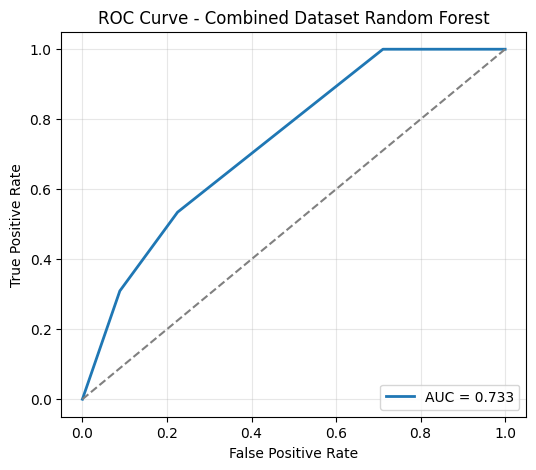

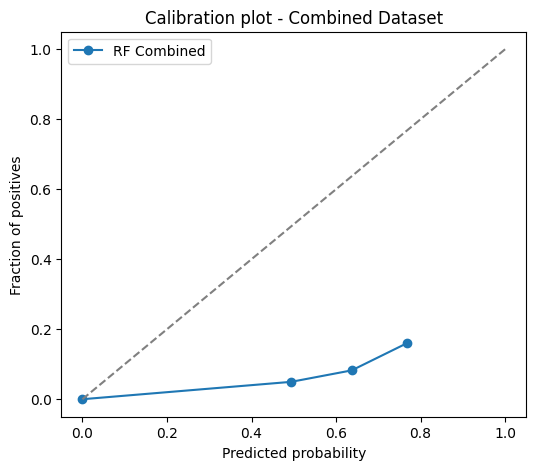

In [15]:
#------ROC Curve for the combined dataset-------
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
y_proba = clf.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, th = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Combined Dataset Random Forest")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
#------Calibration plot for the combined dataset-------
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='RF Combined')
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel('Predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot - Combined Dataset')
plt.legend()
plt.show()                    

In [16]:
#------Cross-validation AUC for the combined dataset-------
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_auc = cross_val_score(rf, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
print("RF AUC: {:.3f} ± {:.3f}".format(rf_auc.mean(), rf_auc.std()))
lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear', random_state=42)
lr_auc = cross_val_score(lr, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
print("LR AUC: {:.3f} ± {:.3f}".format(lr_auc.mean(), lr_auc.std()))



RF AUC: 0.730 ± 0.004
LR AUC: 0.730 ± 0.004


In [17]:
#-----Find correlations between variables in the combined dataset-------
disease_cols = ['heart_disease', 'stroke', 'cardio_disease', 'diabetes']
disease_corr = df_combined[disease_cols].corr()
print("Disease Correlation Matrix:")
print(disease_corr)

Disease Correlation Matrix:
                heart_disease    stroke  cardio_disease  diabetes
heart_disease        1.000000  0.180438       -0.023555 -0.009558
stroke               0.180438  1.000000       -0.022169 -0.008995
cardio_disease      -0.023555 -0.022169        1.000000 -0.134352
diabetes            -0.009558 -0.008995       -0.134352  1.000000


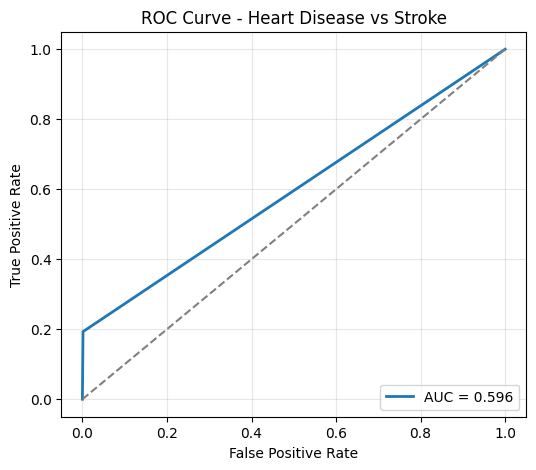

In [18]:
#ROC curve between heart_disease and stroke:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
y_true = df_combined['stroke']
y_scores = df_combined['heart_disease']
roc_auc = roc_auc_score(y_true, y_scores)
fpr, tpr, th = roc_curve(y_true, y_scores)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Heart Disease vs Stroke")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
